<a href="https://colab.research.google.com/github/RailGun15/Data-Science-en-el-Juzgado-10-GBCA/blob/main/Ignacio_Keegan_Proyecto_Data_Science_en_el_Juzgado_10_GBCA_%7C_EDV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyecto Data Science en el Juzgado 10 GBCA | EDV

<img src="https://i.ibb.co/PQjhtPK/Logo-Datos-Vivos.png" width="200px">

Organizado por [EscuelaDeDatosVivos.AI](https://EscuelaDeDatosVivos.AI)

Alumno/a: Ignacio Keegan

Linkedin: https://www.linkedin.com/in/ignacio-keegan-5b850122/

Github: https://github.com/RailGun15

---







Objetivos:

- Limpiar los datos y reportar inconsistencias. Ejemplo sacar y rremplazar los nulos
- Preparar los datos para poder hacer clustering (todos numéricos)
- Hacer análisis exploratorio y describir los datos
- Crear un modelo de clustering con 3 ó 4 clusters (mas no es difícil de interpretar).

Algunos de los puntos de interés del juzgado:

- Estadística descriptiva sobre los datos
- Encontrar inconsistencias en los datos
- Describir los casos según su comportamiento general (se propone clustering)
- Conocer cuales son los casos mas propensos de ser apelados (se propone como decision tree)

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime as dt
import matplotlib.pyplot as plt

### 1)  Lectura de datos

In [ ]:
from google.colab import auth

auth.authenticate_user() # vayan al link que les aparece, copien y peguen el código para autenticarse con suusuario de google

import gspread 

from oauth2client.client import GoogleCredentials

gc = gspread.authorize(GoogleCredentials.get_application_default())

In [ ]:
spread_data = gc.open_by_url('https://docs.google.com/spreadsheets/d/1uAi-Yfq-rJl_cqQaVe9Fv1rLlBJcmEtDpUB0NTOrLAs/edit?usp=sharing')
sheet = spread_data.worksheet('set_de_datos_con_perspectiva_de_genero')
sheel_all = sheet.get_all_values()

In [ ]:
data=pd.DataFrame.from_records(sheel_all[1:], columns=sheel_all[0])

In [ ]:
data

In [ ]:
%%capture 
!pip install funpymodeling

In [ ]:
%matplotlib inline

In [ ]:
%%capture
!pip install seaborn --upgrade

In [ ]:
import seaborn as sns
from pandas_profiling import ProfileReport
from funpymodeling.exploratory import freq_tbl, status, profiling_num, cat_vars, num_vars, corr_pair
from funpymodeling.data_prep import todf

## 1) Análisis exploratorio de datos

In [ ]:
status(data)

,variable,q_nan,p_nan,q_zeros,p_zeros,unique,type
0,N,0,0.0,0,0.0,3014,object
1,NRO_REGISTRO,0,0.0,0,0.0,2940,object
2,FECHA_RESOLUCION,0,0.0,0,0.0,910,object
3,FIRMA,0,0.0,0,0.0,4,object
4,MATERIA,0,0.0,0,0.0,8,object
...,...,...,...,...,...,...,...
57,DECISION_DE_FONDO_TSJ,0,0.0,0,0.0,2,object
58,N_REGISTRO_Y_TOMO_TSJ,0,0.0,0,0.0,2,object
59,LINK_TSJ,0,0.0,0,0.0,3,object
60,RECURSO_EXTRAORDINARIO_Y_RECURRENTE,0,0.0,0,0.0,3,object


---

###Elimino primero los datos vacios, los convierto a NaN primero y luego elimino

In [ ]:
data2 = data.copy()

In [ ]:
data2 = data2.replace('',np.nan)

##### Aqui, me encuentro con un dilema, para identificar unicamente los registros, tomo la combinacion de la columna N, NRO_REGISTRO Y FECHA_RESOLUCION aunque revisando manualmente encuentro casos con registros duplicados (en bases a estas columnas) y aun tienen informacion distinta. Mi decision es por las dudas de eliminar estos registros porque sino tendria que crear un indice propio para tener en cuenta estos casos

In [ ]:
data2 = data2.dropna(how='all',subset = ['N','NRO_REGISTRO','FECHA_RESOLUCION'])

In [ ]:
data2 = data2.drop_duplicates(subset = ['N','NRO_REGISTRO','FECHA_RESOLUCION'])

In [ ]:
pd.set_option('display.max_rows', 400)

In [ ]:
status(data2)

In [ ]:
from google.colab.data_table import DataTable

##### Cuando se importaron los datos, muchas columnas estaban repetidas, esto permite identificarlas de forma unica

In [ ]:
cols = []
rename = ["N_REGISTRO_Y_TOMO_TSJ","N_REGISTRO_Y_TOMO_CAMARA","LINK_CAMARA","LINK_TSJ,ASENTAMIENTO_O_VILLA"]
count = 1
for column in data2.columns:
    if column in rename:
      cols.append(f'{column}{count}')
      count+=1
      continue
    cols.append(column)
data2.columns = cols

In [ ]:
DataTable(data2, max_columns=70)

##### Si bien no lo utilize para el modelo, esto permite limpiar los datos de fecha y de tiempo para utilizarlos en el analisis exploratorio

In [ ]:
data2bis = data2.copy()

In [ ]:
data2bis[['FECHA_RESOLUCION','FECHA_DEL_HECHO','FECHA_DE_INICIO_DEL_HECHO','FECHA_DE_FINALIZACIÓN_DEL_HECHO']] = data2bis[['FECHA_RESOLUCION','FECHA_DEL_HECHO','FECHA_DE_INICIO_DEL_HECHO','FECHA_DE_FINALIZACIÓN_DEL_HECHO']].replace(regex={r'_': '/','200$':'2020'})

In [ ]:
data2bis[['FECHA_RESOLUCION','FECHA_DEL_HECHO','FECHA_DE_INICIO_DEL_HECHO','FECHA_DE_FINALIZACIÓN_DEL_HECHO']] = data2bis[['FECHA_RESOLUCION','FECHA_DEL_HECHO','FECHA_DE_INICIO_DEL_HECHO','FECHA_DE_FINALIZACIÓN_DEL_HECHO']].apply(lambda x: pd.to_datetime(x,errors = 'coerce', format = '%d/%m/%Y'))

In [ ]:
data2bis[['HORA_DE_INICIO','DURACION','HORA_DE_CIERRE']] = data2[['HORA_DE_INICIO','DURACION','HORA_DE_CIERRE']].fillna('0:00')

In [ ]:
data2bis['HORA_DE_INICIO'] = pd.to_datetime(data2bis['HORA_DE_INICIO'], format='%H:%M',errors='coerce').dt.time
data2bis['HORA_DE_CIERRE'] = pd.to_datetime(data2bis['HORA_DE_INICIO'], format='%H:%M',errors='coerce').dt.time
data2bis['DURACION'] = pd.to_datetime(data2bis['DURACION'], format='%H:%M',errors='coerce').dt.time

##### Restando los datos anteriores, el resto de las variables corresponden a variables categorias, asi que primero convertimos los NaN en nulo 

In [ ]:
data2.fillna('nulo',inplace=True)

In [ ]:
status(data2)

#### Considero que la variable CONDUCTA es esencial para agrupar los casos de acuerdo a que delito cometen, sin embargo esta variable sufre de una alta cardinalidad asi que vamos a trabajar en agrupar los delitos de tipos parecidos en una categoria

In [ ]:
otros = data2[data2['CONDUCTA'].isin(data2['CONDUCTA'].value_counts()[data2['CONDUCTA'].value_counts() < 20].index)].CONDUCTA.unique()

In [ ]:
delitos_menores = ['desobediencia_a_la_autoridad','uso_indebido_del_espacio_publico','apropiacion_indebida_de_tributos','sancion_generica','ensuciar_bienes','cuidar_coches_sin_autorizacion',
                   'venta_o_consumo_de_bebidas_alcoholicas_fuera_del_horario','permiso_y_planos_de_obra','ejercer_ilegitimamente_una_actividad','obstruccion_de_inspeccion',
                   'acceder_a_lugares_distintos_segun_entrada','arrojar_sustancias_insalubres_en_lugares_publicos','no_realizar_grabado_de_autopartes','organizar_sin_autorizacion_juego',
                   'espejos_retrovisores','placas_de_dominio','pelear_en_lugar_publico','habilitacion_en_infraccion','obligacion_de_exhibir_cartel','arrojar_cosas_que_puedan_causar_lesiones',
                   'afectar_el_desarrollo_del_espectaculo','suministrar_bebidas_alcoholicas']

ingreso = ['ingreso_a_domicilio_sin_autorizacion','ingresar_contra_derecho_admision', 'ingresar_sin_entrada','ingresar_artefactos_pirotecnicos',
          'obstaculizar_ingreso_o_salida', 'exceso_capacidad_ingreso','apariencia_falsa_para_entrar_a_domicilio_o_lugar_privado']   

           
arma = ['tenencia_de_arma','portar_armas_no_convencionales','portacion_de_arma','abuso_de_armas']

transito = ['transporte_de_pasajeros_sin_habilitacion_o_autorizacion','estacionamiento_prohibido','exceso_de_velocidad','delito_contra_seguridad_transito','cuidar_coches_sin_autorizacion',
            'transporte_de_pasajeros_sin_habilitacion','conducir_sin_licencia_que_lo_habilite_por_categoria_de_vehiculo','circular_por_lugar_prohibido','cruce_de_semaforo_en_rojo',
            'estacionamiento_sobre_senda_peatonal','abandono_de_personas','licencia_vencida','zanjas_y_pozos_en_via_publica','conducir_usando_aparato_electronico',
            'ejecucion_de_multa','vehiculo_abandonado','circular_por_carriles_exclusivos','taxis_transportes_escolares_remises_sin_autorizacion','transporte_de_pasajeros'
            ,'no_respetar_carriles','falta_de_poliza_de_seguros','obstruccion_de_via']

documento = ['falsificacion_de_documento','uso_de_documento_falso_o_adulterado','exhibicion_de_documentacion_obligatoria','falsedad_documental_de_certificado_de_aptitud_ambiental',
             'documentacion_sanitaria','suplantación_digital_de_identidad','falsificacion_certificado_medico']

In [ ]:
def f(x,otros):
  if x in otros:
    return 'otros'
  else:
    return x

data2['CONDUCTA'] = data2['CONDUCTA'].apply(lambda x : f(x,otros))

MESNNA es todo material
en el que aparecen actos de abuso sexual
y/o se enfocan las partes genitales de la
niña, el niño o el adolescente.

In [ ]:
def f(x,delitos_menores,ingreso,arma,transito,documento):
  if x in delitos_menores:
    return 'delitos_menores'
  elif x in ingreso:
    return 'delitos_de_ingreso_prohibido'
  elif x in arma:
    return 'delitos_de_arma'
  elif x in transito:
    return 'delitos_de_transito'
  elif x in documento:
    return 'delitos_de_documento'
  else:
    return x


data2['CONDUCTA'] = data2['CONDUCTA'].apply(lambda x : f(x,delitos_menores,ingreso,arma,transito,documento))

#### Ahora limpiar los datos de otras variables que usaremos

In [ ]:
data2['VIOLENCIA_DE_GENERO'] = data2['VIOLENCIA_DE_GENERO'].replace('SI','si')
data2['VIOLENCIA_DE_GENERO'] = data2['VIOLENCIA_DE_GENERO'].replace('NO','no')
data2['VIOLENCIA_DE_GENERO'] = data2['VIOLENCIA_DE_GENERO'].replace('s/d','nulo')

data2['V_FISICA'] = data2['V_FISICA'].replace('SI','si')
data2['V_FISICA'] = data2['V_FISICA'].replace('NO','no')
data2['V_FISICA'] = data2['V_FISICA'].replace('s/d','nulo')

data2['V_PSIC'] = data2['V_PSIC'].replace('SI','si')
data2['V_PSIC'] = data2['V_PSIC'].replace('NO','no')
data2['V_PSIC'] = data2['V_PSIC'].replace('s/d','nulo')

data2['V_ECON'] = data2['V_ECON'].replace('SI','si')
data2['V_ECON'] = data2['V_ECON'].replace('NO','no')
data2['V_ECON'] = data2['V_ECON'].replace('s/d','nulo')

data2['V_SEX'] = data2['V_SEX'].replace('SI','si')
data2['V_SEX'] = data2['V_SEX'].replace('NO','no')
data2['V_SEX'] = data2['V_SEX'].replace('s/d','nulo')

data2['V_SOC'] = data2['V_SOC'].replace('SI','si')
data2['V_SOC'] = data2['V_SOC'].replace('NO','no')
data2['V_SOC'] = data2['V_SOC'].replace('s/d','nulo')

data2['V_AMB'] = data2['V_AMB'].replace('SI','si')
data2['V_AMB'] = data2['V_AMB'].replace('NO','no')
data2['V_AMB'] = data2['V_AMB'].replace('s/d','nulo')

data2['V_SIMB'] = data2['V_SIMB'].replace('SI','si')
data2['V_SIMB'] = data2['V_SIMB'].replace('NO','no')
data2['V_SIMB'] = data2['V_SIMB'].replace('s/d','nulo')

In [ ]:
data3 = data2.copy()

##### Si bien este variable tendria que ser analizado con un trabajo mas profundo en cuanto al contenido de textos o de sentimientos incluso, voy a agruparlos de manera burda para observar si tienen un impacto en el modelo

In [ ]:
data3.loc[data2['FRASES_AGRESION'].str.contains('matar'),'FRASES_AGRESION']= 'te voy a matar'
data3.loc[data2['FRASES_AGRESION'].str.contains('puta'),'FRASES_AGRESION']= 'hija de puta'

In [ ]:
otros = data3[data3['FRASES_AGRESION'].isin(data3['FRASES_AGRESION'].value_counts()[data3['FRASES_AGRESION'].value_counts() < 4].index)].FRASES_AGRESION.unique()

In [ ]:
def f(x,otros):
  if x in otros:
    return 'otros'
  else:
    return x

data3['FRASES_AGRESION'] = data3['FRASES_AGRESION'].apply(lambda x : f(x,otros))

#### Genero acusado tiene datos que pueden agruparse en otras categorias para bajar la cardinalidad

In [ ]:
data3['GENERO_ACUSADO/A'] = data3['GENERO_ACUSADO/A'].replace('nn','nulo')
data3['GENERO_ACUSADO/A'] = data3['GENERO_ACUSADO/A'].replace('Masculino','masculino')
data3['GENERO_ACUSADO/A'] = data3['GENERO_ACUSADO/A'].replace('s/d','nulo')

data3['GENERO_ACUSADO/A'] = data3['GENERO_ACUSADO/A'].replace({'usuario_de_facebook':'redes_sociales','usuario_de_twitter':'redes_sociales','usuario_de_cuenta_de_google':'redes_sociales',
                                  'usuario_de_instagram':'redes_sociales','usuario_de_skype':'app_de_mensajeria',
                                   'usuario_de_imgur':'redes_sociales','usuario_de_chatstep':'app_de_mensajeria',
                                   'usuario_de_whatsapp':'app_de_mensajeria','usuario_de_skout':'redes_sociales'})

In [ ]:
data3['NACIONALIDAD_ACUSADO/A'] = data3['NACIONALIDAD_ACUSADO/A'].replace('s/d','nulo')
data3['NACIONALIDAD_ACUSADO/A'] = data3['NACIONALIDAD_ACUSADO/A'].replace('Argentino','argentino')
data3['NACIONALIDAD_ACUSADO/A'] = data3['NACIONALIDAD_ACUSADO/A'].replace('Peruano','peruano')
data3['NACIONALIDAD_ACUSADO/A'] = data3['NACIONALIDAD_ACUSADO/A'].replace('Venezolano','venezolano')

#### Las edades se pueden agrupar en categorias numericas

In [ ]:
data3['EDAD_ACUSADO/A AL MOMENTO DEL HECHO'] = data3['EDAD_ACUSADO/A AL MOMENTO DEL HECHO'].replace('s/d','nulo')
data3['EDAD_ACUSADO/A AL MOMENTO DEL HECHO'] = data3['EDAD_ACUSADO/A AL MOMENTO DEL HECHO'].replace('6/02/1900','nulo')
data3['EDAD_ACUSADO/A AL MOMENTO DEL HECHO'] = data3['EDAD_ACUSADO/A AL MOMENTO DEL HECHO'].replace('no_correspode','nulo')
data3['EDAD_ACUSADO/A AL MOMENTO DEL HECHO'] = data3['EDAD_ACUSADO/A AL MOMENTO DEL HECHO'].replace('5/02/1900','nulo')
data3['EDAD_ACUSADO/A AL MOMENTO DEL HECHO'] = data3['EDAD_ACUSADO/A AL MOMENTO DEL HECHO'].replace('18-28','23')

In [ ]:
data3['EDAD_ACUSADO/A AL MOMENTO DEL HECHO'] = data3['EDAD_ACUSADO/A AL MOMENTO DEL HECHO'].replace('nulo',np.nan)
data3['EDAD_ACUSADO/A AL MOMENTO DEL HECHO'] = data3['EDAD_ACUSADO/A AL MOMENTO DEL HECHO'].replace('no_corresponde',np.nan)

In [ ]:
data3['EDAD_ACUSADO/A AL MOMENTO DEL HECHO'] = data3['EDAD_ACUSADO/A AL MOMENTO DEL HECHO'].astype(float)

In [ ]:
data3['EDAD_ACUSADO/A AL MOMENTO DEL HECHO_CAT'], saved_bins = pd.qcut(data3['EDAD_ACUSADO/A AL MOMENTO DEL HECHO'], q = 5, retbins = True)
data3['EDAD_ACUSADO/A AL MOMENTO DEL HECHO_CAT'] = data3['EDAD_ACUSADO/A AL MOMENTO DEL HECHO_CAT'].cat.add_categories('nulo/no_corresponde')
data3['EDAD_ACUSADO/A AL MOMENTO DEL HECHO_CAT'] = data3['EDAD_ACUSADO/A AL MOMENTO DEL HECHO_CAT'].fillna(value="nulo/no_corresponde")

#### El nivel de instruccion tanto del acusado como el denunciante se puede convertir en una variable numerica para ver la intensidad del grado educativo

In [ ]:
data3['NIVEL_INSTRUCCION_ACUSADO/A'] = data3['NIVEL_INSTRUCCION_ACUSADO/A'].replace('s/d','nulo')

In [ ]:
data3['NIVEL_INSTRUCCION_ACUSADO/A'] = data3['NIVEL_INSTRUCCION_ACUSADO/A'].replace('s/d',0)
data3['NIVEL_INSTRUCCION_ACUSADO/A'] = data3['NIVEL_INSTRUCCION_ACUSADO/A'].replace({'nulo':0,'no_corresponde':0,'sin_escolarizar':1,'sin_instruccion':1,'primario_incompleto':2,
                                  'primario_completo':3,'secundario_incompleto':4,
                                   'secundario_en_curso':5,'secundario_completo':6,
                                   'terciario_incompleto':7,'terciario_en_curso':8,
                                   'terciario_completo':9,'universitario_incompleto':10,
                                   'universitario_en_curso':11,'universitario_completo':12})

data3['NIVEL_INSTRUCCION_DENUNCIANTE'] = data3['NIVEL_INSTRUCCION_DENUNCIANTE'].replace({'nulo':0,'no_corresponde':0,'sin_escolarizar':1,'sin_instruccion':1,'primario_incompleto':2,
                                  'primario_completo':3,'secundario_incompleto':4,
                                   'secundario_en_curso':5,'secundario_completo':6,
                                   'terciario_incompleto':7,'terciario_en_curso':8,
                                   'terciario_completo':9,'universitario_incompleto':10,
                                   'universitario_en_curso':11,'universitario_completo':12})

In [ ]:
data3['GENERO_DENUNCIANTE'] = data3['GENERO_DENUNCIANTE'].replace('Femenino','femenino')
data3['GENERO_DENUNCIANTE'] = data3['GENERO_DENUNCIANTE'].replace('s/d','nulo')

In [ ]:
data3['NACIONALIDAD_DENUNCIANTE'] = data3['NACIONALIDAD_DENUNCIANTE'].replace('s/d','nulo')
data3['NACIONALIDAD_DENUNCIANTE'] = data3['NACIONALIDAD_DENUNCIANTE'].replace('Peruana','peruana')

In [ ]:
data3['EDAD_DENUNCIANTE_AL_MOMENTO_DEL_HECHO'] = data3['EDAD_DENUNCIANTE_AL_MOMENTO_DEL_HECHO'].replace('s/d','nulo')
data3['EDAD_DENUNCIANTE_AL_MOMENTO_DEL_HECHO'] = data3['EDAD_DENUNCIANTE_AL_MOMENTO_DEL_HECHO'].replace('13/02/1900','nulo')
data3['EDAD_DENUNCIANTE_AL_MOMENTO_DEL_HECHO'] = data3['EDAD_DENUNCIANTE_AL_MOMENTO_DEL_HECHO'].replace('31/01/1900','nulo')
data3['EDAD_DENUNCIANTE_AL_MOMENTO_DEL_HECHO'] = data3['EDAD_DENUNCIANTE_AL_MOMENTO_DEL_HECHO'].replace('nulo',np.nan)
data3['EDAD_DENUNCIANTE_AL_MOMENTO_DEL_HECHO'] = data3['EDAD_DENUNCIANTE_AL_MOMENTO_DEL_HECHO'].replace('no_corresponde',np.nan)

In [ ]:
data3['EDAD_DENUNCIANTE_AL_MOMENTO_DEL_HECHO'] = data3['EDAD_DENUNCIANTE_AL_MOMENTO_DEL_HECHO'].astype(float)

In [ ]:
data3['EDAD_DENUNCIANTE_AL_MOMENTO_DEL_HECHO_CAT'], saved_bins = pd.qcut(data3['EDAD_DENUNCIANTE_AL_MOMENTO_DEL_HECHO'], q = 5, retbins = True)
data3['EDAD_DENUNCIANTE_AL_MOMENTO_DEL_HECHO_CAT'] = data3['EDAD_DENUNCIANTE_AL_MOMENTO_DEL_HECHO_CAT'].cat.add_categories('nulo/no_corresponde')
data3['EDAD_DENUNCIANTE_AL_MOMENTO_DEL_HECHO_CAT'] = data3['EDAD_DENUNCIANTE_AL_MOMENTO_DEL_HECHO_CAT'].fillna(value="nulo/no_corresponde")

In [ ]:
data3['ASENTAMIENTO_O_VILLA_FIX'] = data3['ASENTAMIENTO_O_VILLA'].iloc[:,0]

In [ ]:
data3.drop('ASENTAMIENTO_O_VILLA',axis = 1,inplace = True)

In [ ]:
data3['ASENTAMIENTO_O_VILLA_FIX'] = data3['ASENTAMIENTO_O_VILLA_FIX'].replace('s/d','nulo')
data3['ASENTAMIENTO_O_VILLA_FIX'] = data3['ASENTAMIENTO_O_VILLA_FIX'].replace('NO','no')

In [ ]:
data3['FRECUENCIA_EPISODIOS'] = data3['FRECUENCIA_EPISODIOS'].replace('s/d','nulo')

In [ ]:
data3['RELACION_Y_TIPO_ENTRE_ACUSADO/A_Y_DENUNCIANTE'] = data3['RELACION_Y_TIPO_ENTRE_ACUSADO/A_Y_DENUNCIANTE'].replace('s/d','nulo')

In [ ]:
data3['HIJOS_HIJAS_EN_COMUN'] = data3['HIJOS_HIJAS_EN_COMUN'].replace('s/d','nulo')
data3['HIJOS_HIJAS_EN_COMUN'] = data3['HIJOS_HIJAS_EN_COMUN'].replace('NO','no')
data3['HIJOS_HIJAS_EN_COMUN'] = data3['HIJOS_HIJAS_EN_COMUN'].replace('SI','si')

In [ ]:
data3['MEDIDAD_DE_PROTECCION_VIGENTES_AL_MOMENTO_DEL_HECHO'] = data3['MEDIDAD_DE_PROTECCION_VIGENTES_AL_MOMENTO_DEL_HECHO'].replace('s/d','nulo')
data3['MEDIDAD_DE_PROTECCION_VIGENTES_AL_MOMENTO_DEL_HECHO'] = data3['MEDIDAD_DE_PROTECCION_VIGENTES_AL_MOMENTO_DEL_HECHO'].replace('NO','no')
data3['MEDIDAD_DE_PROTECCION_VIGENTES_AL_MOMENTO_DEL_HECHO'] = data3['MEDIDAD_DE_PROTECCION_VIGENTES_AL_MOMENTO_DEL_HECHO'].replace('SI','si')

In [ ]:
data3['ZONA_DEL_HECHO'] = data3['ZONA_DEL_HECHO'].replace('s/d','nulo')

In [ ]:
data3['NIVEL_INSTRUCCION_DENUNCIANTE'] = data3['NIVEL_INSTRUCCION_DENUNCIANTE'].replace('s/d','nulo')
data3['NIVEL_INSTRUCCION_DENUNCIANTE'] = data3['NIVEL_INSTRUCCION_DENUNCIANTE'].replace('S/D','nulo')
data3['NIVEL_INSTRUCCION_DENUNCIANTE'] = data3['NIVEL_INSTRUCCION_DENUNCIANTE'].replace('nulo',0)

In [ ]:
data3['MODALIDAD_DE_LA_VIOLENCIA'] = data3['MODALIDAD_DE_LA_VIOLENCIA'].replace('doméstica','domestica')

In [ ]:
data4 = data3.copy()

Para facilitar el modelo, voy a agrupar las categorias que menos aparecen en otros

In [ ]:
otros = data4[data4['GENERO_ACUSADO/A'].isin(data4['GENERO_ACUSADO/A'].value_counts()[data4['GENERO_ACUSADO/A'].value_counts() < 20].index)]['GENERO_ACUSADO/A'].unique()

In [ ]:
def f(x,otros):
  if x in otros:
    return 'otros'
  else:
    return x

data4['GENERO_ACUSADO/A'] = data4['GENERO_ACUSADO/A'].apply(lambda x : f(x,otros))

In [ ]:
otros = data4[data4['GENERO_DENUNCIANTE'].isin(data4['GENERO_DENUNCIANTE'].value_counts()[data4['GENERO_DENUNCIANTE'].value_counts() < 10].index)]['GENERO_DENUNCIANTE'].unique()

In [ ]:
def f(x,otros):
  if x in otros:
    return 'otros'
  else:
    return x

data4['GENERO_DENUNCIANTE'] = data4['GENERO_DENUNCIANTE'].apply(lambda x : f(x,otros))

In [ ]:
otros = data4[data4['NACIONALIDAD_ACUSADO/A'].isin(data4['NACIONALIDAD_ACUSADO/A'].value_counts()[data4['NACIONALIDAD_ACUSADO/A'].value_counts() < 20].index)]['NACIONALIDAD_ACUSADO/A'].unique()

In [ ]:
def f(x,otros):
  if x in otros:
    return 'otros'
  else:
    return x

data4['NACIONALIDAD_ACUSADO/A'] = data4['NACIONALIDAD_ACUSADO/A'].apply(lambda x : f(x,otros))

In [ ]:
otros = data4[data4['NACIONALIDAD_DENUNCIANTE'].isin(data4['NACIONALIDAD_DENUNCIANTE'].value_counts()[data4['NACIONALIDAD_DENUNCIANTE'].value_counts() < 10].index)]['NACIONALIDAD_DENUNCIANTE'].unique()

In [ ]:
def f(x,otros):
  if x in otros:
    return 'otros'
  else:
    return x

data4['NACIONALIDAD_DENUNCIANTE'] = data4['NACIONALIDAD_DENUNCIANTE'].apply(lambda x : f(x,otros))

In [ ]:
otros = data4[data4['RELACION_Y_TIPO_ENTRE_ACUSADO/A_Y_DENUNCIANTE'].isin(data4['RELACION_Y_TIPO_ENTRE_ACUSADO/A_Y_DENUNCIANTE'].value_counts()[data4['RELACION_Y_TIPO_ENTRE_ACUSADO/A_Y_DENUNCIANTE'].value_counts() < 12].index)]['RELACION_Y_TIPO_ENTRE_ACUSADO/A_Y_DENUNCIANTE'].unique()

In [ ]:
def f(x,otros):
  if x in otros:
    return 'otros'
  else:
    return x

data4['RELACION_Y_TIPO_ENTRE_ACUSADO/A_Y_DENUNCIANTE'] = data4['RELACION_Y_TIPO_ENTRE_ACUSADO/A_Y_DENUNCIANTE'].apply(lambda x : f(x,otros))

#### Dato interesante, en general el que denuncia tiene un menor nivel de instruccion con respecto al acusado

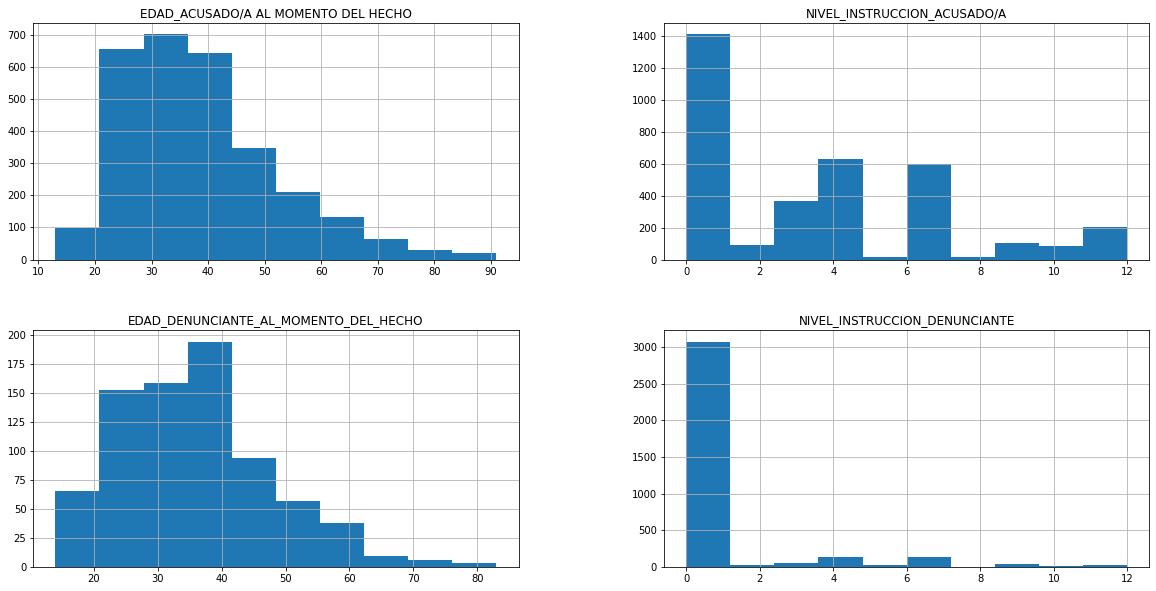

In [ ]:
data4.hist(figsize = (20,10))
plt.show()

In [ ]:
freq_tbl(data4)

         N  frequency  percentage  cumulative_perc
0     nulo        486    0.137990         0.137990
1     2705          2    0.000568         0.138558
2     2978          2    0.000568         0.139125
3     2837          2    0.000568         0.139693
4      233          2    0.000568         0.140261
...    ...        ...         ...              ...
3024   550          1    0.000284         0.998864
3025   161          1    0.000284         0.999148
3026  1087          1    0.000284         0.999432
3027   404          1    0.000284         0.999716
3028  1927          1    0.000284         1.000000

[3029 rows x 4 columns]

----------------------------------------------------------------

     NRO_REGISTRO  frequency  percentage  cumulative_perc
0          1905.1          6    0.001704         0.001704
1             672          4    0.001136         0.002839
2             693          4    0.001136         0.003975
3             616          3    0.000852         0.004827
4     

In [ ]:
var_numericas = data4[['EDAD_ACUSADO/A AL MOMENTO DEL HECHO','EDAD_DENUNCIANTE_AL_MOMENTO_DEL_HECHO','NIVEL_INSTRUCCION_ACUSADO/A','NIVEL_INSTRUCCION_DENUNCIANTE']].fillna(0)

In [ ]:
data_final=pd.get_dummies(data4[['CONDUCTA','VIOLENCIA_DE_GENERO','V_FISICA','V_PSIC','V_ECON']], drop_first=True)

In [ ]:
x_data = pd.concat((data_final,var_numericas),axis = 1)

## 2) Preparación de datos

Hay una diferencia entre el `NO` y el `NO_CORRESPONDE`, no corresponde es que por ejemplo la resolución esta hablando de conducir alcholizado, y esa columna tiene algo relacionado a violencia de género, entonces es "NO CORRESPONDE" que esa columna tenga valor.


Para crear modelos van a tener que pasar todo a numérico. 

### **Importante**: Pre-selección de variables y preparación

En general cuando empiezan un proyecto, intenten hacer una selección de variables que tenga sentido. Si no entienden o dudan de una variable es mejor que la saquen.

#### Algunos tips/cosas a notar: 

Les paso cosas que normalmente miro, y voy a dejar unos días sin resolverlas así se los dejo a uds para que practiquen. Hay varias cosas a revisar:

- Presten atención a la dupla `N`, `NRO_REGISTRO`.
- No tiene sentido dejar: `FECHA_RESOLUCION` (quizas si quieren hacer un medición a lo largo del tiempo). 
- `HORA_DE_INICIO` tampoco tiene sentido para analizar, pero que tal 
- `DECISION_CAMARA_DE_APELACIONES` tiene muchas categorías, pienso yo que algunas de ellas podrían resumirse en una para aumentar la representatividad.
- Nacionalidad tiene varios tipos que son el mismo. 
- De nacionalidad también se puede desprender otra variable (esto es el feature engineering), ejemplo: crear variable "es_argentino", y/o "es_latino".
- La variable `DURACION`, `NIVEL_INSTRUCCION_DENUNCIANTE` son variablees candidatas a que se useen como numéricas ya que de essta manera se puede embeber el concepto de orden, por ejemplo: primaria = 1, universidad = 5. 
- Hay varias variables que tienen varias categorias que representan lo mismo: `SI`,`Si`, `si`. 
- Eliminar variables con valores constantes/únicos.
- Miren bien la variable: `GENERO_ACUSADO/A`, ¿que transformación se les ocurre? ¿qué variable o variables nuevas pueden generarse?


Como podrán ver es muy importarte hacer las preguntas indicadas, mas allá de que lo procesen, elaboren las preguntas que les gustaría o necesitan respuesta para continuar. Algunas que fuí viendo ya las estoy averiguando y les haré saber en estos días las rtas. 

## 3) Creación de modelos

### 3.1) Modelo de clustering


Crear y describir dos modelos: k-means y un HDBSCAN (simplemente porque este segundo es mas robusto).

Luego expliquenlo con la función `coord_plot`, [video explicativo](https://www.youtube.com/watch?v=8v3b0cCGQSk).

Si no tienen tiempo, vayan por el k-means. Recuerden normalizar los datos antes con StandarScaler.


In [ ]:
x_data

,EDAD_ACUSADO/A AL MOMENTO DEL HECHO,EDAD_DENUNCIANTE_AL_MOMENTO_DEL_HECHO,CONDUCTA_amenazas,CONDUCTA_conducir_con_mayor_grado_de_alcohol_o_bajo_efectos_de_estupefacientes,CONDUCTA_contactar_menor_por_medio_de_tecnologias_para_cometer_delitos_contra_su_integridad_sexual,CONDUCTA_daños,CONDUCTA_delitos_de_arma,CONDUCTA_delitos_de_documento,CONDUCTA_delitos_de_ingreso_prohibido,CONDUCTA_delitos_de_transito,CONDUCTA_delitos_menores,CONDUCTA_estupefacientes,CONDUCTA_hostigamiento,CONDUCTA_impedimento_de_contacto_de_menor_con_padre_no_conviviente,CONDUCTA_incendios_y_otros_estragos,CONDUCTA_incumplimiento_deberes_familiares,CONDUCTA_incumplir_clausura,CONDUCTA_lesiones,CONDUCTA_mesnna_masnna,CONDUCTA_otros,CONDUCTA_revender_entradas,CONDUCTA_usurpacion,VIOLENCIA_DE_GENERO_si,V_FISICA_no_corresponde,V_FISICA_nulo,V_FISICA_si,V_PSIC_no_corresponde,V_PSIC_nulo,V_PSIC_si,V_ECON_no_corresponde,V_ECON_nulo,V_ECON_si,NIVEL_INSTRUCCION_ACUSADO/A,NIVEL_INSTRUCCION_DENUNCIANTE
0,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0
1,17.0,17.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,5
2,50.0,23.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,7,0
3,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0
4,34.0,NaN,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3708,31.0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,6,0
3709,37.0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0
3710,76.0,NaN,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0
3711,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0


In [ ]:
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()
std_scaler.fit(x_data)
x_data_norm=std_scaler.transform(x_data)


In [ ]:
from sklearn.cluster import KMeans

cl_model = KMeans(
    n_clusters=3,
    init='k-means++',
    max_iter=500, 
    random_state=0
)

cl_model.fit(x_data_norm)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=500,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=0)

In [ ]:
cluster_var='cluster' # definan nombre de var de clustering
x_data_cl=x_data.copy() # hagan copia de los datos de TR para no perderlos
x_data_cl[cluster_var]=cl_model.predict(x_data_norm) # ojo aca! el predict es de los datos normalizados

In [ ]:
x_data_cl['cluster'].value_counts()

0    2552
1     967
2       3
Name: cluster, dtype: int64

In [ ]:
from funpymodeling.model_validation import coord_plot

In [ ]:
plt.figure(figsize=(25,5))

d_orig, d_transf = coord_plot(x_data_cl, cluster_var)

#### K-means basicamente me agrupa los datos en dos clusters 
1. Delitos de violencia de genero
2. Otros delitos que no estan relacionados con violencia de genero

El tercer cluster con 11 casos es dificil de explicar, esta relacionado mas con la variable CONDUCTA en 'otros'

In [ ]:
d_transf

,CONDUCTA_amenazas,CONDUCTA_conducir_con_mayor_grado_de_alcohol_o_bajo_efectos_de_estupefacientes,CONDUCTA_contactar_menor_por_medio_de_tecnologias_para_cometer_delitos_contra_su_integridad_sexual,CONDUCTA_daños,CONDUCTA_delitos_de_arma,CONDUCTA_delitos_de_documento,CONDUCTA_delitos_de_ingreso_prohibido,CONDUCTA_delitos_de_transito,CONDUCTA_delitos_menores,CONDUCTA_estupefacientes,CONDUCTA_hostigamiento,CONDUCTA_impedimento_de_contacto_de_menor_con_padre_no_conviviente,CONDUCTA_incendios_y_otros_estragos,CONDUCTA_incumplimiento_deberes_familiares,CONDUCTA_incumplir_clausura,CONDUCTA_lesiones,CONDUCTA_mesnna_masnna,CONDUCTA_otros,CONDUCTA_revender_entradas,CONDUCTA_usurpacion,VIOLENCIA_DE_GENERO_si,V_FISICA_no_corresponde,V_FISICA_nulo,V_FISICA_si,V_PSIC_no_corresponde,V_PSIC_nulo,V_PSIC_si,V_ECON_no_corresponde,V_ECON_nulo,V_ECON_si,cluster
0,1.000000,0.0,0.0,0.000000,0.298202,0.0,0.290923,0.0,0.904133,0.0,1.000000,1.000000,0.091003,1.0,0.0,0.238316,0.0,0.185639,0.0,0.713268,0.995863,0.0,0.0,1.000000,0.0,0.0,1.0,0.0,0.0,1.0,0
1,0.000000,1.0,1.0,0.014565,1.000000,1.0,1.000000,1.0,1.000000,1.0,0.065127,0.219374,1.000000,0.0,1.0,0.000000,1.0,1.000000,1.0,1.000000,0.000000,1.0,0.0,0.000000,1.0,0.0,0.0,1.0,0.0,0.0,1
2,0.749041,0.0,0.0,1.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,1.000000,0.0,0.000000,0.0,0.000000,1.000000,0.0,1.0,0.637022,0.0,1.0,0.0,0.0,1.0,0.0,2


#### Probemos con HDBSCAN

In [ ]:
%%capture
!pip install hdbscan

In [ ]:
import hdbscan

In [ ]:
model_hdb = hdbscan.HDBSCAN()
model_hdb.fit(x_data)

HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
        approx_min_span_tree=True, cluster_selection_epsilon=0.0,
        cluster_selection_method='eom', core_dist_n_jobs=4,
        gen_min_span_tree=False, leaf_size=40,
        match_reference_implementation=False, memory=Memory(location=None),
        metric='euclidean', min_cluster_size=5, min_samples=None, p=None,
        prediction_data=False)

#### De por si podemos ver mucho ruido en el cluster -1 y muchos clusters

In [ ]:
from funpymodeling.exploratory import freq_tbl, todf
freq_tbl(model_hdb.labels_.astype('str'))

,0,frequency,percentage,cumulative_perc
0,-1,1152,0.327087,0.327087
1,21,200,0.056786,0.383873
2,18,171,0.048552,0.432425
3,6,32,0.009086,0.441511
4,168,31,0.008802,0.450312
5,16,30,0.008518,0.458830
6,15,30,0.008518,0.467348
7,63,28,0.007950,0.475298
8,66,26,0.007382,0.482680
9,193,24,0.006814,0.489495


In [ ]:
model_hdb2 = hdbscan.HDBSCAN(min_cluster_size=80).fit(x_data)

In [ ]:
freq_tbl(model_hdb2.labels_.astype('str'))

,0,frequency,percentage,cumulative_perc
0,1,2119,0.601647,0.601647
1,0,662,0.187961,0.789608
2,-1,331,0.093981,0.883589
3,2,239,0.067859,0.951448
4,3,171,0.048552,1.000000


In [ ]:
cluster_var='cluster'
x_data_cl=x_data.copy() 
x_data_cl[cluster_var]=model_hdb2.labels_ 

In [ ]:
x_data_cl=x_data_cl[x_data_cl['cluster']!=-1]

In [ ]:
plt.figure(figsize=(25,5))


from funpymodeling.model_validation import coord_plot
d_orig, d_transf = coord_plot(x_data_cl, cluster_var)

### Clusters:

1. Cluster 0 delitos de violencia de genero
2. Cluster 1 otros delitos
3. Cluster 2 otros delitos mas relacionados a menores
4. Cluster 3 delitos enmarcados en 'otros'

In [ ]:
d_transf 

,CONDUCTA_amenazas,CONDUCTA_conducir_con_mayor_grado_de_alcohol_o_bajo_efectos_de_estupefacientes,CONDUCTA_contactar_menor_por_medio_de_tecnologias_para_cometer_delitos_contra_su_integridad_sexual,CONDUCTA_daños,CONDUCTA_delitos_de_arma,CONDUCTA_delitos_de_documento,CONDUCTA_delitos_de_ingreso_prohibido,CONDUCTA_delitos_de_transito,CONDUCTA_delitos_menores,CONDUCTA_estupefacientes,CONDUCTA_hostigamiento,CONDUCTA_impedimento_de_contacto_de_menor_con_padre_no_conviviente,CONDUCTA_incendios_y_otros_estragos,CONDUCTA_incumplimiento_deberes_familiares,CONDUCTA_incumplir_clausura,CONDUCTA_lesiones,CONDUCTA_mesnna_masnna,CONDUCTA_otros,CONDUCTA_revender_entradas,CONDUCTA_usurpacion,VIOLENCIA_DE_GENERO_si,V_FISICA_no_corresponde,V_FISICA_nulo,V_FISICA_si,V_PSIC_no_corresponde,V_PSIC_nulo,V_PSIC_si,V_ECON_no_corresponde,V_ECON_nulo,V_ECON_si,EDAD_ACUSADO/A AL MOMENTO DEL HECHO,EDAD_DENUNCIANTE_AL_MOMENTO_DEL_HECHO,NIVEL_INSTRUCCION_ACUSADO/A,NIVEL_INSTRUCCION_DENUNCIANTE,cluster
0,1.000000,0.0,0.000000,0.652036,0.251757,0.00000,0.304848,0.000000,1.000000,0.0,1.000000,1.000000,0.128036,1.000000,0.000000,1.00000,0.000000,0.039275,0.0,0.548727,1.000000,0.000000,1.0,1.000000,0.000000,1.0,1.000000,0.000000,1.0,1.00000,0.905938,1.0,1.000000,1.000000,0
1,0.223951,1.0,0.169184,1.000000,1.000000,0.82712,1.000000,1.000000,0.761503,1.0,0.299529,0.156206,1.000000,0.053997,1.000000,0.27721,0.001128,0.163756,1.0,1.000000,0.080698,0.917414,0.0,0.067916,0.917414,0.0,0.084917,0.917414,0.0,0.07615,1.000000,0.0,0.957405,0.005285,1
2,0.000000,0.0,1.000000,0.656749,0.049810,1.00000,0.140732,0.961385,0.000000,0.0,0.000000,0.307764,0.354644,0.000000,0.185354,0.00000,1.000000,0.000000,0.0,0.253317,0.000000,1.000000,0.0,0.000000,1.000000,0.0,0.000000,1.000000,0.0,0.00000,0.000000,0.0,0.000000,0.000000,2
3,0.000000,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,1.000000,0.0,0.000000,0.000000,1.000000,0.0,0.000000,1.000000,0.0,0.000000,1.000000,0.0,0.00000,0.000000,0.0,0.000000,0.000000,3


In [ ]:
from sklearn.metrics import silhouette_score, silhouette_samples

sil_avg = silhouette_score(x_data, model_hdb2.labels_)

In [ ]:
sample_silhouette_values = silhouette_samples(x_data, model_hdb2.labels_)

In [ ]:
res_sil=pd.DataFrame({'sil_value': sample_silhouette_values, 'cluster': model_hdb2.labels_})

#### Se puede ver bien que en general el modelo predice medianamente bien los clusters pero en particular el cluster 2

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


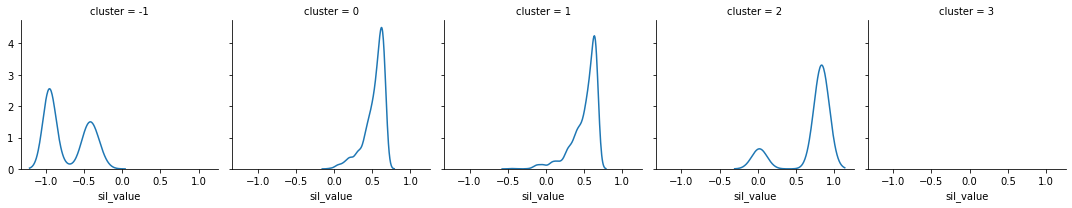

In [ ]:
g = sns.FacetGrid(res_sil, col='cluster')
g = g.map(sns.kdeplot, 'sil_value')

In [ ]:
res_sil.groupby('cluster').mean('sil_value')

,sil_value
cluster,
-1,-0.716340
0,0.529933
1,0.510427
2,0.703245
3,1.000000


---

### 3.2) Modelo de decision tree

Un poquito mas **avanzado**, el juzgado le gustaría conocer las reglas que hacen que Si ya hicieron el de clustering, pueden probar crear un modelo explicativo con decision tree, generenlo con pocos niveles y luego extraigan las reglas leyendo el árbol.  No mas de 2/3 variables por regla:

IF condicion 1 AND condicion2 THEN ...




#### Elegimos nuestra variable y

In [ ]:
data4['SI_NO_RECURRENTE'] = data4['SI_NO_RECURRENTE'].replace({'si_fiscalia':'si','si_defensa':'si','si_defensa_particular':'si','si_infractor':'si',
                                                               'si_interprete':'si','si_apoderada_consejo':'si','si_querella':'si',
                                                              'si_defensa_y_fiscalia':'si','si_perito':'si',
                                                              'Si_Defensa_Particular':'si','si_querella_y_defensa':'si'})

In [ ]:
data5 = data4[(data4['SI_NO_RECURRENTE'] != 'nulo') & (data4['SI_NO_RECURRENTE'] != 'contienda')]

#### El primer problema esta a la vista, tengo muchas mas datos de 'no' apelacion que 'si' por ende debo balancearlas

In [ ]:
data5['SI_NO_RECURRENTE'].value_counts()

no    1811
si     158
Name: SI_NO_RECURRENTE, dtype: int64

In [ ]:
data_x = pd.get_dummies(data5[['CONDUCTA','VIOLENCIA_DE_GENERO','V_ECON']], drop_first=True)
data_y = data5['SI_NO_RECURRENTE']

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

undersample = RandomUnderSampler(sampling_strategy={'no': 200, 'si': 155})

In [ ]:
x_under, y_under = undersample.fit_resample(data_x, data_y)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
from sklearn import tree
model = tree.DecisionTreeClassifier(min_samples_leaf=5,min_samples_split=10,max_depth=6) 
model.fit(x_under, y_under)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=6, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [ ]:
from IPython.display import Image  
from sklearn.tree import export_graphviz # tienen que tener instalado graphviz: https://graphviz.org/download/
import pydotplus

#### Distintas iteraciones del arbol muestran varios cambios pero en general hay una tendencia (que hay que profundizar), generalmente los delitos de transito y relacionados con armas tienen mas posibilidad de ser apelados, es necesario separar en mas categorias los delitos de estos tipos para que categorias espeficias son mas apeladas o no

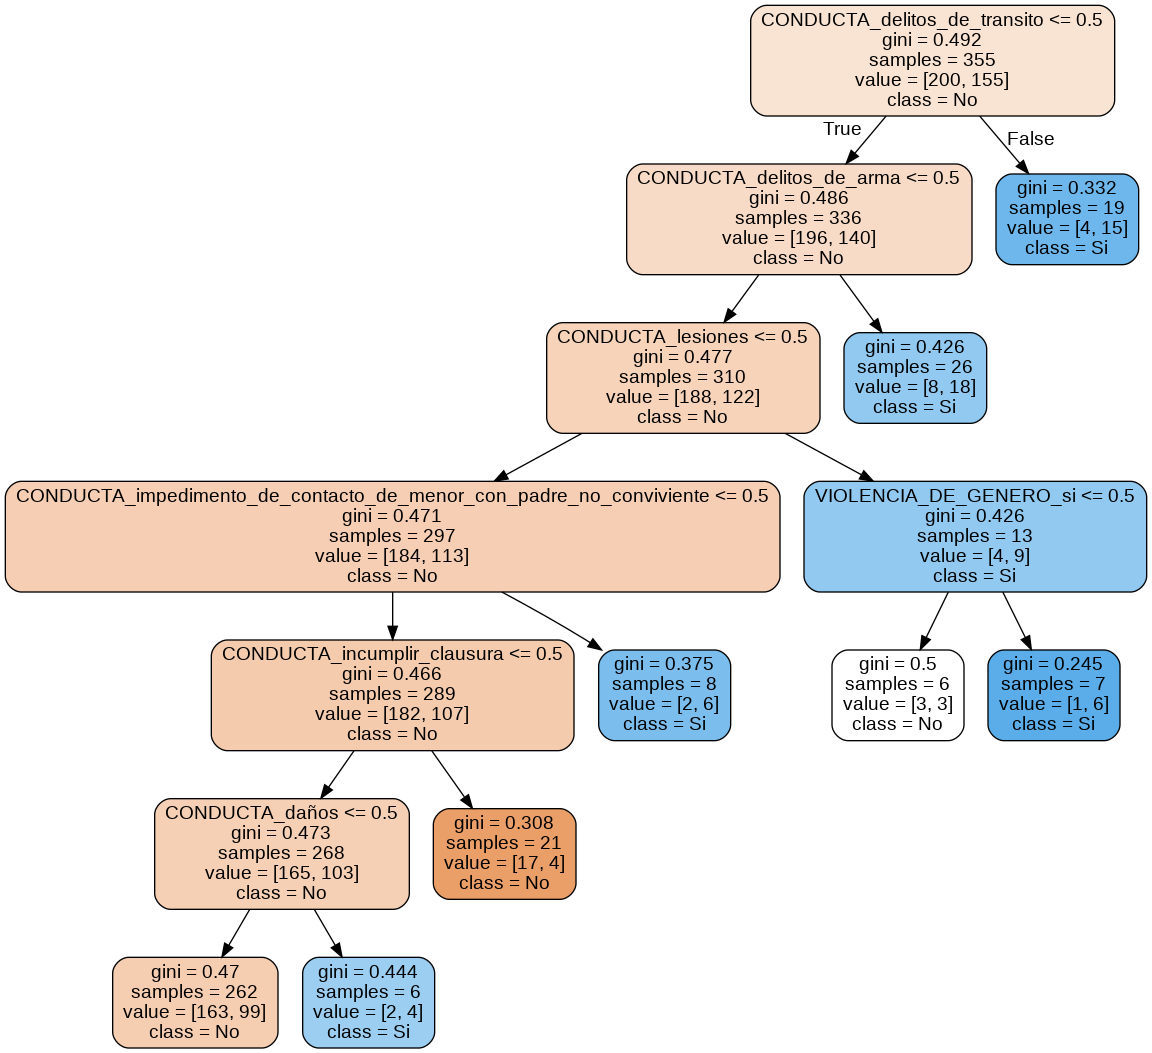

In [ ]:
dot_data = tree.export_graphviz(model, 
                                out_file=None, 
                                feature_names=list(data_x.columns.values), 
                                class_names=['No', 'Si'], 
                                rounded=True, 
                                filled=True)

graph = pydotplus.graph_from_dot_data(dot_data)

Image(graph.create_png())

### 3.3) NLP: Crear nubes de palabras de las resoluciones

En el set de datos, la columna `LINK` tiene el link a las resoluciones pdf que fueron pasadas a texto. Varias cosas se pueden hacer, una de la mas sencillas es nubes de palabras.

Se pueden hacer nubes de palabras basadas en categorías, por ejemplo, tomar todas las resoluciones de violencia de género, o todas las de conducir bajos los efectos del alcohol, etc.

Este artículo en Python puede ayudarlos: https://medium.com/@a.fernandez.troyano/nube-de-palabras-word-cloud-con-python-a-partir-de-varias-webs-111e94220822

En R les recomiendo: https://www.tidytextmining.com/

--- 

Conclusiones:


De acuerdo a lo presentado aqui, podemos presentar dos conclusiones generales que demandan mas analisis

1. Tanto con k-means como con hdbscan hay 2 grupos, gente que comete delitos relacionados a violencia de genero y otros delitos, esto no significa que no puedan ocurrir ambas cosas pero son dos grupos bien delimitados. Con HDBSCAN nos encontramos con 2 grupos mas, uno relacionado con delitos relacionados con menores y otro mas vinculado al agrupamiento de delitos que arme en 'otros', claramente hay que ahondar mas en porque este agrupamiento es relevamente en el modelo

2. En cuanto a la probabilidad de apelacion, encuentro que con delitos relacionados al transito o relacionados con armas hay una tendencia a la apelacion, seguramente porque estos delitos tienden a ser mas graves y por lo tanto hay mas incentivo a incurrir en el costo de tiempo y recursos para apelar. Sin embargo el agrupamiento de 'delitos de arma' y 'delitos de transito' es muy simple para especificar mas en detalle. La proxima version del modelo tiene que desagregar estas categorias para verlas mas en detalle.

En general, encontramos que analizar la variable de CONDUCTA, que tipo de delito comete la persona, es una variable esencial para ambos modelos que hay que refinar para mejorar el modelo.